In [1]:
from data_gen import synthetic_dataset_pyro
import matplotlib.pyplot as plt
import numpy as np


In [3]:
help(synthetic_dataset_pyro)

Help on function synthetic_dataset_pyro in module data_gen:

synthetic_dataset_pyro(n: int = 2000, beta: float = 2.0, num_proxies: int = 10, shuffle_pct: float = 0.0, prior_type: str = 'gaussian', sigma_x: float = 1.0, sigma_y: float = 1.0, seed: int | None = None)
    Data generator for a simple causal model with proxies and latent confounders.
    Args:
      n: int               (number of samples)
      beta: float          (treatment effect strength)
      num_proxies: int     (number of proxy covariates)
      shuffle_pct: float   (fraction of proxies to shuffle,i.e., uninformative proxies, 0.0 to 1.0)
      prior_type: str      ('gaussian' or 'bimodal' for latent confounder z)
      sigma_x: float       (noise level for proxy covariates)
      sigma_y: float       (noise level for outcome y)
      seed: int | None     (random seed for reproducibility)
    Returns:
      x: [n, num_proxies]   (proxy covariates)
      t: [n]               (binary treatment)
      y: [n]           

# Some Plots

In [4]:
# Plot the distribution of the variables
def plot_distribution(data, variable_name="z"):
    plt.figure(figsize=(8, 6))
    plt.hist(data[variable_name].numpy(), bins=30, density=True, alpha=0.7)
    plt.title(f"Distribution of {variable_name}", fontsize=16)
    plt.xlabel(variable_name, fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()

## Normal prior on z

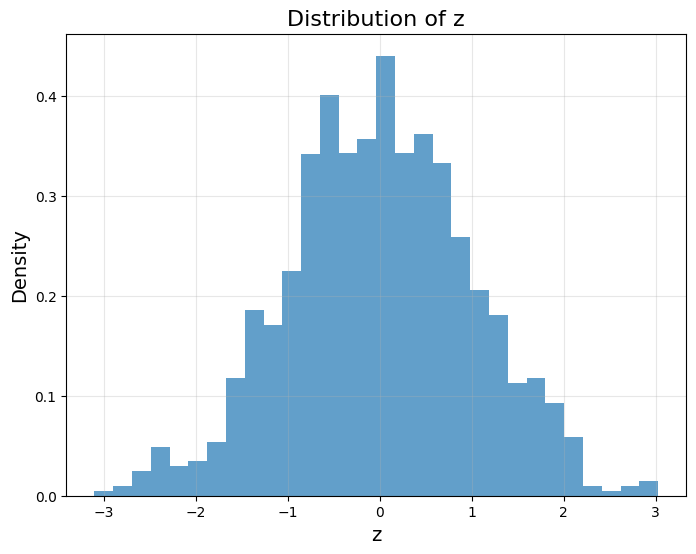

In [5]:
data = synthetic_dataset_pyro(n=1000, beta=2.0, num_proxies=5, shuffle_pct=0.2, seed=42)
plot_distribution(data, "z")

## bimodal prior on z

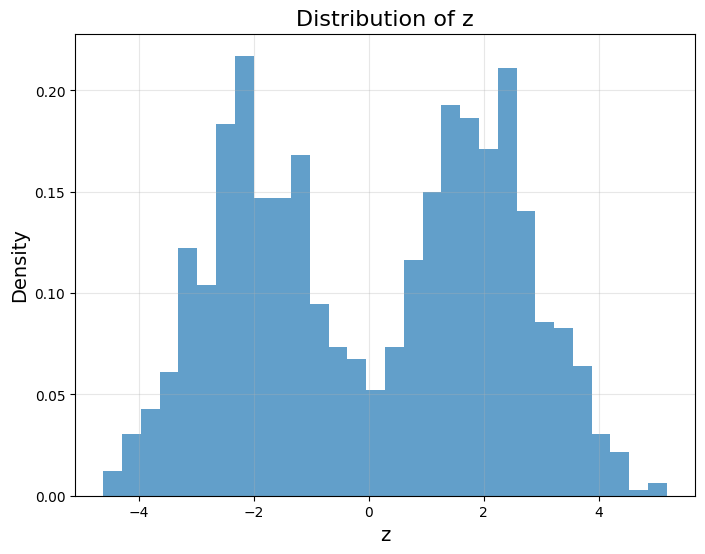

In [6]:
data_bimodal = synthetic_dataset_pyro(n=1000, beta=2.0, num_proxies=5, shuffle_pct=0.2, seed=42, prior_type="bimodal")
plot_distribution(data_bimodal, "z")

In [7]:
def plot_outcome_vs_z_and_x(
    betas,
    n=1000,
    num_proxies=5,
    shuffle_pct=0.2,
    prior_type="bimodal",
    sigma_x=1.0,
    sigma_y=1.0,
    seed=42,
    proxy_index=0
):
    """
    For each value in `betas`, generate synthetic data and produce two scatter plots:
      1. Outcome y vs. latent z (colored by treatment)
      2. Outcome y vs. proxy x[:, proxy_index] (colored by treatment)

    Args:
      betas        : list or array of beta values to iterate over
      n            : number of data points (passed to synthetic_dataset_pyro)
      num_proxies  : number of proxy dimensions
      shuffle_pct  : fraction of proxies to shuffle (make uninformative)
      prior_type   : "gaussian" or "bimodal" for latent z
      sigma_x      : noise standard deviation in proxies
      sigma_y      : noise standard deviation in outcome
      seed         : base random seed; will be offset by index to ensure different draws
      proxy_index  : which column of X to plot against y
    """
    num_betas = len(betas)
    fig, axes = plt.subplots(
        nrows=num_betas,
        ncols=2,
        figsize=(10, 4 * num_betas),
        squeeze=False
    )

    for i, beta in enumerate(betas):
        # Generate data for this beta (offset seed so repeats differ)
        data = synthetic_dataset_pyro(
            n=n,
            beta=beta,
            num_proxies=num_proxies,
            shuffle_pct=shuffle_pct,
            prior_type=prior_type,
            sigma_x=sigma_x,
            sigma_y=sigma_y,
            seed=seed + i
        )

        z = data["z"].numpy()
        x = data["x"].numpy()
        y = data["y"].numpy()
        t = data["t"].numpy()

        idx0 = (t == 0)
        idx1 = (t == 1)

        # Plot 1: y vs. z
        ax_z = axes[i][0]
        ax_z.scatter(z[idx0], y[idx0], s=10, alpha=0.3, label="t=0", color="C2")
        ax_z.scatter(z[idx1], y[idx1], s=10, alpha=0.3, label="t=1", color="C3")
        ax_z.set_xlabel("z", fontsize=10)
        ax_z.set_ylabel("y", fontsize=10)
        ax_z.set_title(f"β = {beta} | Outcome y vs. latent z", fontsize=11)
        ax_z.legend(fontsize=9)

        # Plot 2: y vs. x[:, proxy_index]
        ax_x = axes[i][1]
        ax_x.scatter(x[idx0, proxy_index], y[idx0], s=10, alpha=0.3, label="t=0", color="C2")
        ax_x.scatter(x[idx1, proxy_index], y[idx1], s=10, alpha=0.3, label="t=1", color="C3")
        ax_x.set_xlabel(f"x[:, {proxy_index}]", fontsize=10)
        ax_x.set_ylabel("y", fontsize=10)
        ax_x.set_title(f"β = {beta} | Outcome y vs. proxy x[{proxy_index}]", fontsize=11)
        ax_x.legend(fontsize=9)

    plt.tight_layout()
    plt.show()


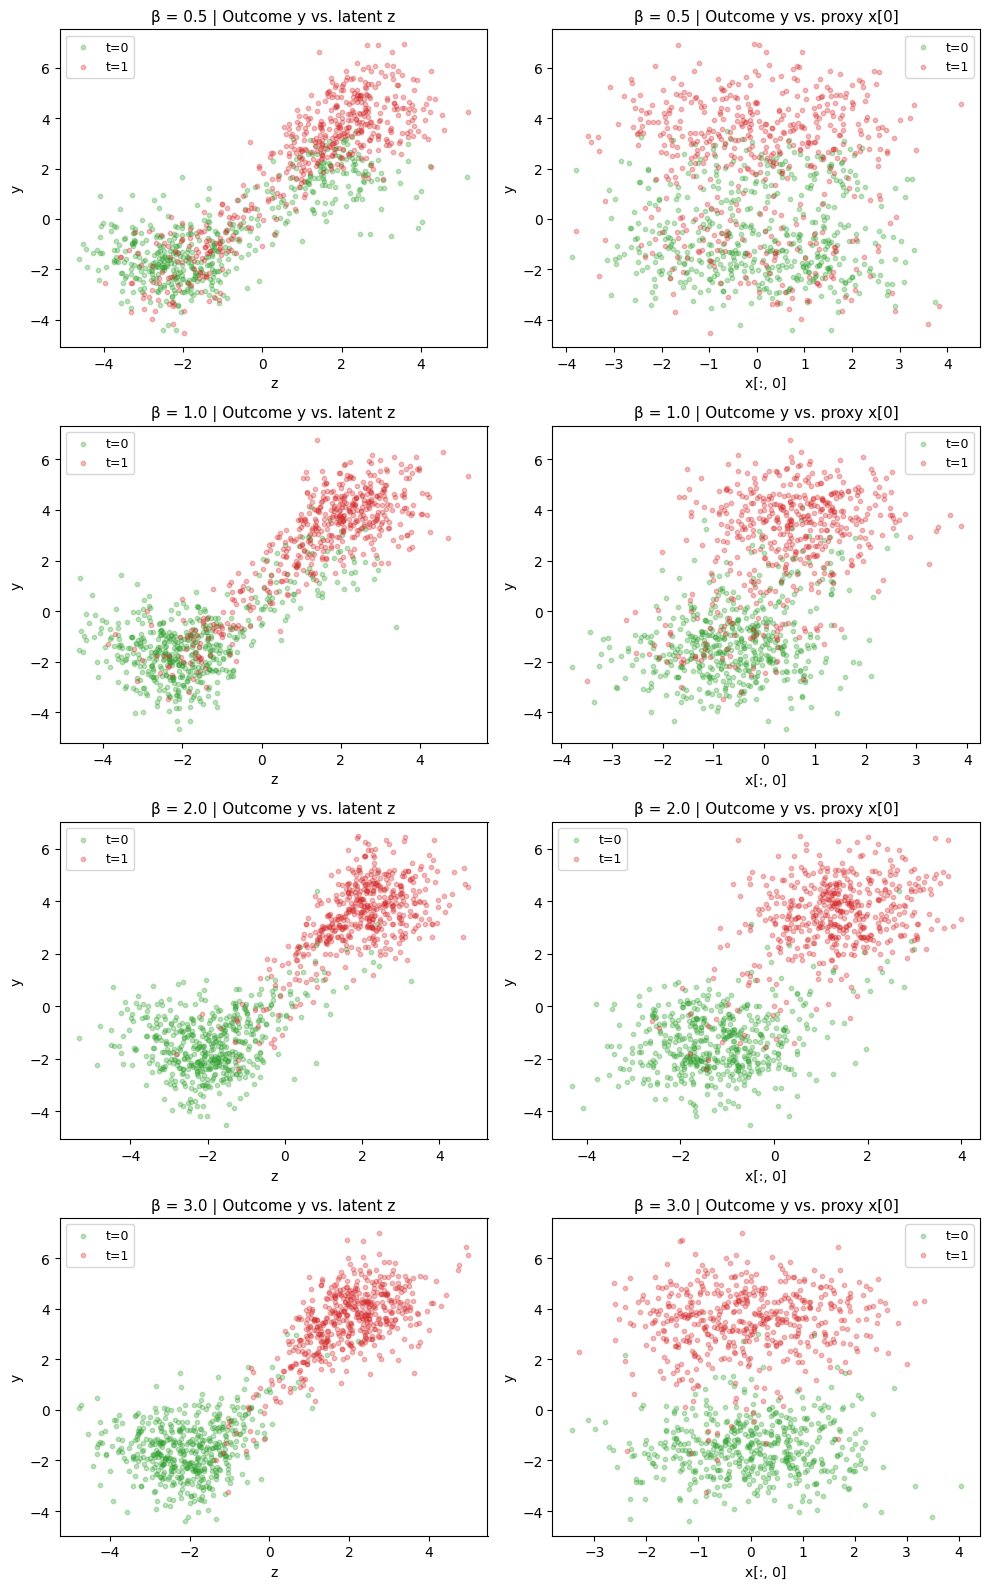

In [8]:
betas = [0.5, 1.0, 2.0, 3.0]
plot_outcome_vs_z_and_x(
    betas,
    n=1000,
    num_proxies=5,
    shuffle_pct=0.5,
    prior_type="bimodal",
    sigma_x=1.0,
    sigma_y=1.0,
    seed=42,
    proxy_index=0
)


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_z_x_correlations(data, proxy_indices=None, cmap="vlag"):
    """
    Plot a heatmap of Pearson correlations between the latent confounder z
    and each proxy covariate x_j.

    Args:
      data           : dict containing keys "z" (shape [n]) and "x" (shape [n, p])
      proxy_indices  : list or array of column indices of X to include (default: all)
      cmap           : colormap for the heatmap (default "vlag"; requires matplotlib ≥3.1)

    Produces:
      A single‐row heatmap where the x‐axis is the proxy index and
      the color intensity is corr(z, x[:, j]).
    """
    z = data["z"].numpy().flatten()   # shape [n]
    x = data["x"].numpy()             # shape [n, p]

    n, p = x.shape
    if proxy_indices is None:
        proxy_indices = np.arange(p)
    else:
        proxy_indices = np.array(proxy_indices, dtype=int)

    # Compute Pearson correlation between z and each selected x_j
    corrs = np.array([
        np.corrcoef(z, x[:, j].flatten())[0, 1]
        for j in proxy_indices
    ])

    # Prepare a 1×len(proxy_indices) “matrix” for imshow
    corr_matrix = corrs.reshape(1, -1)

    fig, ax = plt.subplots(figsize=(max(6, len(proxy_indices)*0.5), 2))
    im = ax.imshow(
        corr_matrix,
        aspect="auto",
        cmap=cmap,
        vmin=-1,
        vmax=1
    )
    ax.set_xticks(np.arange(len(proxy_indices)))
    ax.set_xticklabels(proxy_indices, rotation=0, fontsize=9)
    ax.set_yticks([0])
    ax.set_yticklabels(["corr(z, x_j)"], fontsize=9)
    ax.set_xlabel("Proxy index j", fontsize=10)
    ax.set_title("Correlation between z and each proxy x_j", fontsize=11)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.2)
    cbar.set_label("Pearson correlation", fontsize=9)

    plt.tight_layout()
    plt.show()


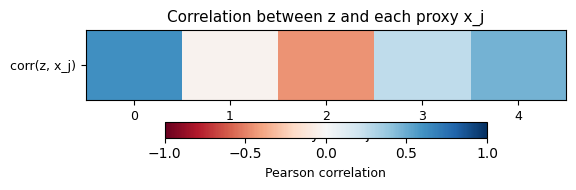

In [10]:
data = synthetic_dataset_pyro(n=1000, beta=2.0, num_proxies=5, shuffle_pct=0.0, seed=0)
plot_z_x_correlations(data, cmap="RdBu")

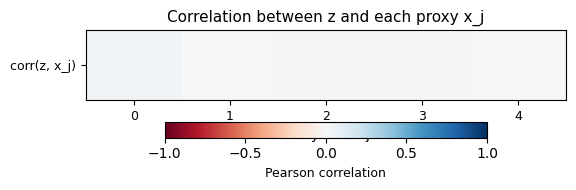

In [11]:
data = synthetic_dataset_pyro(n=1000, beta=2.0, num_proxies=5, shuffle_pct=1.0, seed=0)
plot_z_x_correlations(data, cmap="RdBu")

In [12]:
def binned_diff(var, t, y, num_bins=15):
    """
    For a scalar array 'var' (shape [n]), compute
      E[Y | T=1, var in bin] - E[Y | T=0, var in bin]
    across num_bins equal-width bins between var.min() and var.max().
    Returns: (bin_centers, diffs)
    """
    bins = np.linspace(var.min(), var.max(), num_bins + 1)
    centers = 0.5 * (bins[:-1] + bins[1:])
    diffs = []

    for i in range(num_bins):
        mask = (var >= bins[i]) & (var < bins[i+1])
        if mask.sum() == 0:
            diffs.append(np.nan)
            continue

        y_t1 = y[mask & (t == 1)]
        y_t0 = y[mask & (t == 0)]
        if (y_t1.size == 0) or (y_t0.size == 0):
            diffs.append(np.nan)
        else:
            diffs.append(y_t1.mean() - y_t0.mean())

    return centers, np.array(diffs)

In [18]:
data = synthetic_dataset_pyro(n=10000, beta=2.0, num_proxies=5, shuffle_pct=0.2, seed=42)


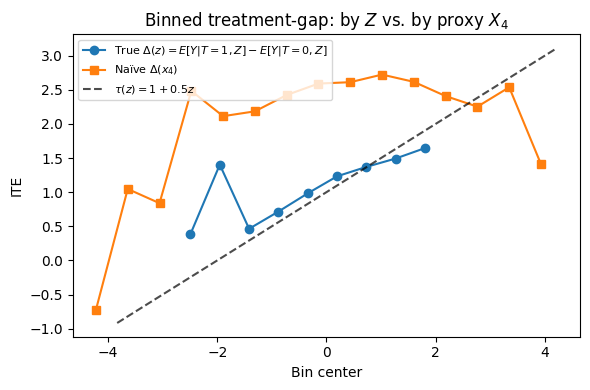

In [19]:

# Extract variables from the data dictionary
z = data["z"].numpy()
t = data["t"].numpy()
y = data["y"].numpy()
x = data["x"].numpy()

# Binning by Z (ground truth)
z_centers, delta_z = binned_diff(z, t, y, num_bins=15)

# Binning by a chosen proxy X_j (e.g., j=0)
j = 4
xj_centers, delta_xj = binned_diff(x[:, j], t, y, num_bins=15)


# Plot both on the same figure for comparison
plt.figure(figsize=(6,4))
plt.plot(z_centers, delta_z, '-o', label=r"True $\Delta(z)=E[Y|T{=}1,Z]-E[Y|T{=}0,Z]$")
plt.plot(xj_centers, delta_xj, '-s', label=fr"Naïve $\Delta(x_{{{j}}})$")

# Overlay the analytic line tau(z) = 1 + 0.5 z for reference
z_line = np.linspace(z.min(), z.max(), 200)
plt.plot(z_line, 1 + 0.5 * z_line, 'k--', alpha=0.7, label=r"$\tau(z)=1+0.5z$")

plt.xlabel("Bin center")
plt.ylabel("ITE")
plt.legend(loc="upper left", fontsize=8)
plt.title(f"Binned treatment-gap: by $Z$ vs. by proxy $X_{{{j}}}$")
plt.tight_layout()
plt.show()


# proxy extimated ite

A trivial idea is to assume a linear relationship: $Y_i=\alpha+\beta\cdot X_i + \gamma T$ to estimate the the ATE